# Setup

In [1]:
# Import packages
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.__version__ # 2.x

'2.3.0'

## Setup input pipeline

In [2]:
# Load dataset
dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

print(train_dataset.element_spec, test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [3]:
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [4]:
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

In [5]:
BUFFER_SIZE = 5000
BUFFER_BS = 32

# Create optimized input pipeline
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BS).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BS).prefetch(tf.data.experimental.AUTOTUNE)

## Data prepocessing

In [6]:
VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 512

# Create custom standardization to clean data
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

# Create a tex vecotrizer
encoder_layer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = custom_standardization,
    split="whitespace",
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)


# Learn encoder layer on train features
encoder_layer.adapt(train_dataset.map(lambda x, y: x))

In [7]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder_layer(text), label

# Vectorize the datasets
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

# Create optimized model input
train_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_BS)
test_dataset = test_dataset.cache().prefetch(buffer_size=BUFFER_BS)

## Modelling

### Using Bi-Directional LSTM

In [8]:
def get_bilstm_model():
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    # Normalization and dropout regularizer
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Sequence processing layer
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    # Dense layers with dropout regulaarizer
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation="relu"))

    # We add the classifier on top
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [9]:
# Define embeeding
EMBEDDING_DIM = 100

# Instantiate model
model = get_bilstm_model()

# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train and validation
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]
)

Epoch 1/10
782/782 [==============================] - 64s 81ms/step - loss: 0.5324 - accuracy: 0.7134 - val_loss: 0.3747 - val_accuracy: 0.8562
Epoch 2/10
782/782 [==============================] - 63s 80ms/step - loss: 0.2531 - accuracy: 0.9028 - val_loss: 0.3256 - val_accuracy: 0.8625
Epoch 3/10
782/782 [==============================] - 64s 81ms/step - loss: 0.1427 - accuracy: 0.9502 - val_loss: 0.3415 - val_accuracy: 0.8625
Epoch 4/10
782/782 [==============================] - 64s 81ms/step - loss: 0.0792 - accuracy: 0.9740 - val_loss: 0.4222 - val_accuracy: 0.8656


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


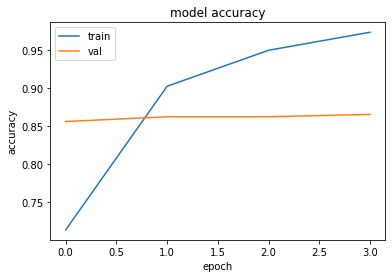

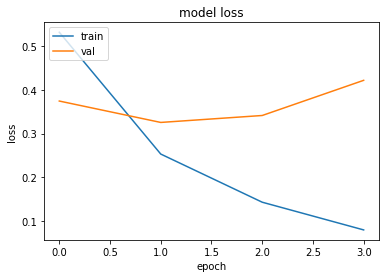

In [10]:
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [11]:
# Evaluate learned model on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")

782/782 [==============================] - 22s 29ms/step - loss: 0.4115 - accuracy: 0.8652
Test loss: 0.4114796817302704 | Test accuracy: 0.8651999831199646
